In [ ]:
!pip install scikit-learn pandas pyyaml
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.5/882.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# dataset splited train:valid:test = 7:2:1 (total 2862(2006:569:287)), agu x preprocessing 640*640,auto orient

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="RNnRbjBGhOkE1aA2L1wU")
project = rf.workspace("project-uuw6i").project("pre-eklj4")
version = project.version(2)
dataset = version.download("yolov8")



# not splited dataset(total 2862) agu x preprocessing 640*640, auto orient


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="RNnRbjBGhOkE1aA2L1wU")
project = rf.workspace("project-uuw6i").project("pre-eklj4")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dependency ultralytics==8.0.196 is required but found version=8.3.8, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to pre-3 in yolov8:: 100%|██████████| 5728/5728 [00:00<00:00, 6928.87it/s]


# k-fold start

In [ ]:
import yaml
import ultralytics
import sklearn
import pandas as pd

데이터 세트에 대한 라벨 txt 정렬

In [ ]:
from pathlib import Path

dataset_path = Path("/content/pre-3/train")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*labels/*.txt"))  # all data in 'labels'

yaml 파일을 열어 클래스 레이블의 인덱스를 추출(클래스 네임 수정 해야함. (문자열로)

In [ ]:
yaml_file = "/content/pre-3/data.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(range(len(classes)))

print(classes) #클래스 추출
print(cls_idx) #클래스를 0~10으로 index

['36.Rjohnson', '37.Rnixon', '38.Jford', '39.Jcarter', '40.Rreagan', '41.HWbush', '42.Bclinton', '43.Jbush', '44.Bobama', '45.Dtrupm', '46.Jbiden']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


데이터 프레임을 통해 라벨을 인덱스로 만들고 cls_idx를 정렬
                                                    

In [ ]:
import pandas as pd

indx = [label.stem for label in labels]  # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
print(indx)

['-0615402585_140_jpg.rf.6cfe60de8bfb24a8b21d586e72fc122d', '-1-_jpg.rf.2cc610de17633d9fe34f8639e1fbcf93', '-10-_jpg.rf.75025d550d60cae8dab909ac8f8e92fe', '-10-jpg_jpg.rf.57c14977d394b637e53f241a119e816f', '-11-_jpg.rf.6518f5aef6b751569014474b31b929eb', '-12-_jpg.rf.27e56b9cfc02ba98d7432ec3c8ece483', '-12-jpg_jpg.rf.75bf852bb2f098afee4a7fd2a76ab39c', '-13-_jpg.rf.6227a3a1a2bdc293cc0f1d8ae63c1522', '-14-_jpg.rf.7fbc730053c6ada2bae496111667baaa', '-14-jpg_jpg.rf.08d6db02aba9e040457a6e656516aff4', '-15-_jpg.rf.5600365b50ea7494112370672ef62c5f', '-15-jpg_jpg.rf.9d24bf71d80ee0c3f2bebd0201733236', '-2-_jpg.rf.675be26173f4f2220ba87364c0d7c231', '-2-jpg_jpg.rf.8b9338b57ff7279ae627e73b78dfe549', '-3-_jpg.rf.e4204c5ee239ef6e0d8cee5bb7b10e21', '-3-jpg_jpg.rf.9b12d4c0601278f1f1760fe7b33b70b2', '-4-_jpg.rf.20bc5eff61a92d4f1285e63883d29788', '-4-jpg_jpg.rf.d005b483992f20fc0b7c87fa9488ae98', '-5-_jpg.rf.3c44cb97c520be7fb6017b14bd8a74fb', '-5-jpg_jpg.rf.c0ac7e11bfecd5909171202b9e7fd521', '-6-_jpg.rf.5

In [ ]:
from collections import Counter

for label in labels:
    lbl_counter = Counter()

    with open(label, "r") as lf:
        lines = lf.readlines()

    for line in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(line.split(" ")[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0)  # replace `nan` values with `0.0`

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


sklearn.model_selection을 통해서 KFold를 불러옵니다.
split은 자유
random_sata = 20(숫자 크기는 상관없음 사용자 마음) 이라는 것을 통해서 랜덤하지만 난수의 일관성을 보장하기 하여 재현가능성을 보장 하기 위해 설정한다.


In [ ]:
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)  # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
kfolds

[(array([   0,    1,    2, ..., 2856, 2858, 2859]),
  array([   4,   11,   12,   13,   18,   27,   29,   32,   33,   44,   45,   49,   52,   53,   55,   56,   59,   65,   66,   67,  109,  113,  130,  136,  139,  141,  143,  148,  153,  155,  163,  171,  174,  175,  181,  187,  189,  193,  197,  200,  207,  213,  214,  216,  226,  238,  249,  250,  251,  253,  254,  255,
          256,  257,  265,  266,  267,  269,  270,  272,  275,  279,  288,  292,  298,  302,  303,  307,  312,  313,  317,  321,  323,  324,  326,  328,  335,  338,  344,  351,  355,  357,  368,  369,  381,  389,  391,  392,  396,  398,  403,  412,  413,  421,  427,  431,  438,  442,  443,  448,  451,  463,  464,  467,
          476,  480,  487,  496,  500,  501,  509,  524,  536,  540,  542,  549,  553,  555,  569,  572,  576,  583,  590,  594,  596,  602,  614,  615,  616,  627,  630,  635,  641,  642,  644,  648,  659,  671,  673,  674,  684,  685,  687,  688,  689,  694,  695,  702,  709,  711,  712,  713,  714,  72

train과 val 데이터의 k-fold

In [ ]:
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df.loc[labels_df.iloc[train].index, f"split_{idx}"] = "train"  # train에 대해 업데이트
    folds_df.loc[labels_df.iloc[val].index, f"split_{idx}"] = "val"      # val에 대해 업데이트

In [ ]:
folds_df

,split_1,split_2,split_3,split_4,split_5
-0615402585_140_jpg.rf.6cfe60de8bfb24a8b21d586e72fc122d,train,train,train,val,train
-1-_jpg.rf.2cc610de17633d9fe34f8639e1fbcf93,train,train,train,val,train
-10-_jpg.rf.75025d550d60cae8dab909ac8f8e92fe,train,train,train,train,val
-10-jpg_jpg.rf.57c14977d394b637e53f241a119e816f,train,train,train,train,val
-11-_jpg.rf.6518f5aef6b751569014474b31b929eb,val,train,train,train,train
...,...,...,...,...,...
zachary-taylor-president4_jpg.rf.2af538d3ba27de2b4c499c2cadf4141a,train,val,train,train,train
zachary-taylor-president5_jpg.rf.354a4ca07db422298d6eebf01adaeefc,val,train,train,train,train
zachary-taylor-president6_jpg.rf.c45a43243370a60d4c8407f8931d1708,train,val,train,train,train
zachary-taylor-president7_jpg.rf.f559b5c841e379653974c8938e28d8d9,train,train,train,train,val


In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"split_{n}"] = ratio

In [ ]:
ok_extensions = ['.jpg']

for ext in ok_extensions:
    # `dataset_path / "images"`는 Path 객체여야 하므로, `"images"`를 Path 객체로 이어붙여야 합니다.
    for image in (dataset_path / "images").rglob(f"*{ext}"):
        # 여기에서 `image`에 대해 필요한 작업 수행
        print(image)  # 또는 원하는 작업을 수행

/content/pre-3/train/images/download_jpg.rf.7689ccc70423d758c53c8457a6e53ee4.jpg
/content/pre-3/train/images/john-tyler-president2_jpg.rf.cd72c5ce859932b56a66600c5ab8291e.jpg
/content/pre-3/train/images/images_jpg.rf.887109b0c7a30769c5715409677e9754.jpg
/content/pre-3/train/images/images_jpg.rf.81c1998912e84dfcc5ee115cc00add27.jpg
/content/pre-3/train/images/download_jpg.rf.b3204941fa945025d7b36b98ef7e282f.jpg
/content/pre-3/train/images/20230601_191723_14_jpg.rf.f1970f146b7f6647f4adb85cb982faef.jpg
/content/pre-3/train/images/Joe-Biden_15_jpeg.rf.4e9a01da88c2493e6d07feb3456c6347.jpg
/content/pre-3/train/images/images-273-_jpeg.rf.cc01927a49dc0ba79348a4bb0f66d7e8.jpg
/content/pre-3/train/images/Biden_25_jpeg.rf.b5296ac7361223355261ffda23700779.jpg
/content/pre-3/train/images/images_jpg.rf.fa020ac57df16744f7469c716f9974bf.jpg
/content/pre-3/train/images/images-8-_jpeg.rf.102e010322cf598e9771e238ab7b2094.jpg
/content/pre-3/train/images/images_jpg.rf.3c8215a151e5c3cf53c8e3995f9054b3.jpg
/

각 분할에 대한 디렉터리와 데이터 세트 YAML 파일을 생성합니다

In [ ]:
import datetime

supported_extensions = [".jpg", ".jpeg", ".png"]

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
    images.extend(sorted((dataset_path / "images").rglob(f"*{ext}"))) # rglob으로  모든 하위 디렉토리를 포함한 모든 파일 검색
                                                                      # *와이들 카드를 통해서 .jpg, .jpeg, .png를 모두 찾음

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

In [ ]:
import shutil

for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

선택사항으로 라벨링 데이터를 참조하곳 싶다면 저장

In [ ]:
folds_df.to_csv(save_path / "/content/pre-3/kfold_datasplit 2cha.csv")
fold_lbl_distrb.to_csv(save_path / "/content/pre-3/kfold_label_distribution 2cha.csv")

xl 모델 테스트를 해야하나????

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8l.yaml').load('yolov8l.pt')

100%|██████████| 83.7M/83.7M [00:00<00:00, 236MB/s]


Transferred 559/631 items from pretrained weights


가중치의 호환성이 약간 떨어짐. 모델 아키텍처의 차이로 그럴 수 있음

In [ ]:
print(ds_yamls)

[PosixPath('/content/pre-3/train/2024-10-08_5-Fold_Cross-val/split_1/split_1_dataset.yaml'), PosixPath('/content/pre-3/train/2024-10-08_5-Fold_Cross-val/split_2/split_2_dataset.yaml'), PosixPath('/content/pre-3/train/2024-10-08_5-Fold_Cross-val/split_3/split_3_dataset.yaml'), PosixPath('/content/pre-3/train/2024-10-08_5-Fold_Cross-val/split_4/split_4_dataset.yaml'), PosixPath('/content/pre-3/train/2024-10-08_5-Fold_Cross-val/split_5/split_5_dataset.yaml')]


# k=3이기 전부터 증강 데이터를 이용하게 함/

In [ ]:
augmentation_params = {
    'hsv_h': 0.1,  # Hue 변화
    'hsv_s': 0.1,  # Saturation 변화
    'hsv_v': 0.1,  # Value 변화
    'degrees': 0.1,  # 회전 각도
    'translate': 0.0,  # 이동
    'scale': 0.0,  # 크기 조정
    'shear': 0.1,  # 기울기
    'perspective': 0.0, # 원근감
    'flipud': 0.0,  # 위 아래 반전
    'fliplr': 1.0,  # 좌우 반전
    'bgr': 0.0, # 색 채널
    'mosaic': 0.1,  # 모자이크
    'mixup': 0.1,  # 사진을 섞음
}

results = {}


batch = 0.7
project = "/content/pre-3/kfold_for_fold"
epochs = 50
patience= 6 #성능 개선이 되지 않을때
freeze = 10


for i in range(2):  # k를 두 번 반복하고 싶다면 i를 2로 설정
    for k in range(ksplit):
        dataset_yaml = ds_yamls[k]
        # Train the model with argument True for the first iteration of i
        model.train(
            data=dataset_yaml,
            epochs=epochs,
            batch=batch,
            project=project,
            patience=patience,
            freeze=freeze,
            augment=True  # 첫 번째 반복일 때만 True로 설정
        )

        # For k >= 3, train again with argument False for the second iteration of i
        if k >= 3:  # 두 번째 반복일 때만 False로 설정
            model.train(
                data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                project=project,
                patience=patience,
                freeze=freeze,
                augment=False,
            )

            # Save output metrics for further analysis
            results[k] = model.metrics



Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.yaml, data=/content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=50, time=None, patience=6, batch=0.7, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/pre-3/kfold_for_fold, name=train, exist_ok=False, pretrained=yolov8l.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sa

100%|██████████| 755k/755k [00:00<00:00, 111MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 334MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 70.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.35G reserved, 0.34G allocated, 38.87G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    39466545       145.9         0.648         78.05         263.4        (1, 3, 640, 640)                    list
    39466545       291.7         0.860         33.86         57.48        (2, 3, 640, 640)                    list
    39466545       583.4         1.313         41.02         46.55        (4, 3, 640, 640)                    list
    39466545        1167         2.147         36.77         41.98        (8, 3, 640, 640)                    list
    39466545        2334         3.892         51.38         45.31       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 123 for CUDA:0 27.69G/39.56G (70%) ✅


train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/train/labels... 2288 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2288/2288 [00:01<00:00, 1213.12it/s]

train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/val/labels... 573 images, 85 backgrounds, 0 corrupt: 100%|██████████| 573/573 [00:00<00:00, 976.55it/s]

val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to /content/pre-3/kfold_for_fold/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009609375), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      29.1G      1.295      4.446      1.599        121        640: 100%|██████████| 19/19 [00:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

                   all        573        506    0.00782      0.973     0.0834     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      28.9G      1.067      3.344       1.26        129        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

                   all        573        506    0.00344      0.996     0.0417     0.0273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      28.8G      1.076      2.962      1.237        114        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        573        506      0.205      0.183      0.126     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      28.8G      1.085      2.634      1.234        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        573        506      0.171      0.356      0.199      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      28.8G      1.095      2.332      1.227        121        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        573        506      0.191      0.464      0.259      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      28.9G      1.075      2.098      1.225        113        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        573        506      0.189      0.463      0.207      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      28.9G      1.061      1.863        1.2        123        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        573        506      0.498      0.439      0.418      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      28.9G      1.035      1.676      1.186        143        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        573        506      0.515      0.523      0.498      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      28.9G      1.035      1.574      1.176        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.468      0.539      0.512      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      28.8G     0.9966      1.459      1.173        139        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.497      0.474      0.486      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      28.9G     0.9816      1.356       1.17        125        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.525      0.564      0.539      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      28.8G     0.9716      1.319      1.153        128        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506      0.599      0.626      0.642      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      28.8G      0.973       1.25      1.146        129        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506        0.6      0.602      0.658      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      28.8G      0.947      1.181      1.135        120        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.584       0.64      0.642      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      28.8G     0.9569       1.14       1.13        134        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        573        506      0.612       0.69      0.686      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      28.8G     0.9217      1.097      1.111        136        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.678      0.694      0.731      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      28.8G     0.9153      1.077       1.12        133        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506      0.597      0.713      0.709      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      28.8G     0.9127      1.037      1.112        121        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.715      0.652      0.723      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      28.8G     0.8864       1.01      1.106        134        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.671      0.748      0.754      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      28.8G     0.8926     0.9905      1.101        109        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.696      0.643      0.722      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      28.8G     0.8751      0.951      1.105        136        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.683      0.716      0.758       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      28.8G     0.8747     0.9313      1.095        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.711      0.695      0.761      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      28.8G     0.8535     0.8792      1.091        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.731      0.724      0.785       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        29G     0.8552     0.8971      1.088        137        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.657      0.722      0.749      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      28.8G     0.8374     0.8681      1.074        127        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.746      0.685      0.778      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      28.9G     0.8226      0.844      1.068        112        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.719      0.662      0.756      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      28.8G     0.8235     0.8187      1.066        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.731      0.738      0.773      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      28.9G     0.8138     0.8377      1.063        137        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.736      0.663      0.758       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      28.8G     0.7944     0.7847      1.046        106        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.734        0.7      0.777      0.578
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.138 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


                   all        573        506      0.788      0.806      0.854      0.638
           36.Rjohnson         48         48       0.71      0.896      0.907      0.741
             37.Rnixon         36         36       0.96      0.672      0.873      0.693
              38.Jford         39         39      0.827      0.735      0.841      0.628
            39.Jcarter         40         40      0.567       0.85      0.836      0.664
            40.Rreagan         40         42      0.782      0.937      0.924      0.716
             41.HWbush         37         37      0.516      0.703      0.669      0.485
           42.Bclinton         46         46      0.971      0.738      0.895      0.586
              43.Jbush         36         36      0.571      0.639      0.584      0.429
             44.Bobama         48         48      0.862      0.938      0.952      0.692
             45.Dtrupm         71         71      0.946      0.873      0.949      0.723
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels... 2289 images, 278 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1148.47it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels... 572 images, 80 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 925.70it/s]

val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to /content/pre-3/kfold_for_fold/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0008984375), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      26.6G     0.8835     0.9388      1.099        180        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        572        510      0.855       0.92       0.95      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      26.5G     0.8362     0.8732      1.077        211        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        510      0.871      0.829      0.931       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      26.5G     0.8557     0.9022      1.095        187        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        572        510       0.87      0.807      0.919      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.5G     0.8832     0.9219        1.1        174        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510      0.793      0.818      0.875      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      26.5G     0.8852     0.9593      1.105        148        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510      0.768      0.727      0.836      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      26.5G     0.9012     0.9837      1.111        183        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        510      0.779      0.748      0.825      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      26.5G     0.9045     0.9687       1.11        183        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510       0.72      0.706      0.784      0.588
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train2/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train2/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train2/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


                   all        572        510      0.919      0.958      0.978      0.804
           36.Rjohnson         47         48      0.894      0.979      0.986      0.839
             37.Rnixon         40         40       0.93      0.999      0.994      0.869
              38.Jford         45         46      0.917      0.935      0.985      0.852
            39.Jcarter         45         45          1      0.981      0.995      0.843
            40.Rreagan         36         38      0.801      0.974      0.966      0.792
             41.HWbush         42         42      0.831      0.934      0.952      0.751
           42.Bclinton         50         50      0.937          1      0.993      0.753
              43.Jbush         39         39      0.935      0.735      0.903      0.719
             44.Bobama         60         60      0.977          1      0.995       0.82
             45.Dtrupm         46         46      0.958      0.999      0.994      0.854
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/train/labels... 2289 images, 302 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1161.04it/s]

train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/val/labels... 572 images, 56 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 1131.99it/s]


val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/val/labels.cache
Plotting labels to /content/pre-3/kfold_for_fold/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009140625), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      27.1G     0.8623     0.8916      1.087        110        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        533      0.903      0.863      0.947      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50        27G     0.8615     0.8819      1.085        111        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        533      0.855      0.853      0.921      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      26.9G       0.85     0.8954      1.082        122        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        572        533      0.831      0.811      0.891      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.9G     0.8775     0.9327      1.096        115        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        533      0.836      0.803      0.885      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      26.9G     0.8915     0.9502      1.097        110        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        533      0.748      0.738      0.824      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      26.9G     0.8977     0.9484       1.11        118        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        533      0.772      0.738      0.801      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      26.9G     0.8783     0.9446        1.1        125        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        533      0.814      0.752      0.853      0.631
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train22/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train22/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train22/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


                   all        572        533      0.953      0.957       0.98      0.792
           36.Rjohnson         59         64      0.952      0.935      0.975      0.799
             37.Rnixon         41         42      0.975          1      0.995      0.855
              38.Jford         47         47          1      0.957       0.99      0.802
            39.Jcarter         37         37      0.877          1      0.992      0.826
            40.Rreagan         38         38      0.943          1      0.995      0.817
             41.HWbush         47         47      0.893      0.886      0.952      0.782
           42.Bclinton         61         61          1      0.939      0.995      0.728
              43.Jbush         33         33      0.889      0.848      0.916      0.732
             44.Bobama         52         52      0.981      0.981      0.985      0.788
             45.Dtrupm         65         65      0.975      0.985      0.994      0.816
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/train/labels... 2289 images, 294 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1208.53it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/val/labels... 572 images, 64 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 951.44it/s]


val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/val/labels.cache
Plotting labels to /content/pre-3/kfold_for_fold/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009140625), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      27.1G     0.8453     0.8736      1.087         92        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        522      0.908      0.869      0.946      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      26.9G     0.8471     0.8723       1.08        121        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        572        522      0.791      0.863      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      26.9G      0.857     0.9025       1.09        113        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        522      0.875      0.844      0.926      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.9G     0.8796     0.9241      1.097        118        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        522      0.829      0.822      0.899      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      26.9G     0.8973      0.957      1.113        109        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522      0.751      0.707      0.816      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      26.9G     0.8904     0.9653      1.109        114        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522        0.7      0.794      0.832      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      26.9G        0.9     0.9621       1.11        122        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522      0.795      0.735      0.836      0.628
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


                   all        572        522      0.951      0.953      0.981      0.808
           36.Rjohnson         52         52      0.931          1      0.992      0.851
             37.Rnixon         39         39          1      0.957      0.989      0.844
              38.Jford         32         32       0.94      0.981      0.988      0.804
            39.Jcarter         51         54      0.992      0.981      0.994      0.853
            40.Rreagan         42         43      0.937          1      0.992      0.803
             41.HWbush         41         41      0.919      0.833      0.964      0.798
           42.Bclinton         54         54      0.982      0.995      0.991      0.782
              43.Jbush         29         30      0.904      0.767      0.908      0.735
             44.Bobama         58         58      0.933          1      0.995      0.841
             45.Dtrupm         59         60      0.976      0.983      0.992      0.813
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/train/labels.cache... 2289 images, 294 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/val/labels.cache... 572 images, 64 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]


Plotting labels to /content/pre-3/kfold_for_fold/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0010625), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train2222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      31.3G      0.846     0.8525      1.085        196        640: 100%|██████████| 17/17 [00:12<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        572        522      0.924      0.857      0.947      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      31.2G     0.8369     0.8797      1.079        196        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        522      0.882      0.857      0.932       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      31.2G     0.8447     0.8873      1.083        176        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        572        522       0.85      0.803      0.913      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      31.2G     0.8617     0.8798      1.087        191        640: 100%|██████████| 17/17 [00:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        572        522      0.797      0.853      0.914      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      31.2G     0.8549     0.8992      1.087        180        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        572        522      0.843      0.781      0.892      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      31.2G     0.8908     0.9205      1.115        201        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        572        522      0.779      0.681      0.832      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      31.2G     0.8884     0.9394      1.116        190        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        572        522      0.778      0.768      0.848      0.648
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train2222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train2222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train2222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


                   all        572        522      0.924      0.857      0.947      0.759
           36.Rjohnson         52         52      0.935      0.731      0.944      0.787
             37.Rnixon         39         39      0.995      0.769      0.955      0.802
              38.Jford         32         32      0.949      0.906      0.954      0.769
            39.Jcarter         51         54      0.814      0.981      0.955      0.791
            40.Rreagan         42         43      0.974      0.862      0.975      0.744
             41.HWbush         41         41      0.845      0.665      0.871      0.708
           42.Bclinton         54         54      0.956      0.814       0.95      0.692
              43.Jbush         29         30      0.822       0.77      0.849      0.695
             44.Bobama         58         58       0.95      0.983      0.992      0.833
             45.Dtrupm         59         60      0.964       0.95      0.977      0.799
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/train/labels... 2289 images, 285 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1199.05it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels... 572 images, 73 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 992.07it/s]

val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels.cache


Plotting labels to /content/pre-3/kfold_for_fold/train22222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009218750000000001), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train22222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      27.3G     0.8366     0.8392      1.082         74        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.911      0.859      0.938      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      27.3G     0.8431      0.868       1.08         89        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        514      0.897      0.832      0.932      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      27.2G     0.8567     0.8707      1.081         73        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        514      0.809      0.848      0.909      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      27.2G     0.8692     0.8952      1.095         81        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        514      0.813      0.807      0.876      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      27.2G     0.8843     0.9229      1.108         83        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.738      0.722      0.794      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      27.2G     0.8971     0.9637      1.104         78        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.752      0.742      0.819      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      27.2G      0.891     0.9694      1.103         84        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.756      0.774      0.829      0.629
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train22222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train22222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train22222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


                   all        572        514      0.947      0.955      0.982      0.814
           36.Rjohnson         60         60       0.96      0.983      0.994      0.856
             37.Rnixon         39         39      0.951      0.995      0.994      0.837
              38.Jford         38         38      0.949      0.921       0.99       0.83
            39.Jcarter         33         33       0.89       0.97      0.984      0.844
            40.Rreagan         47         47      0.958          1      0.995      0.835
             41.HWbush         46         46      0.912      0.891      0.949      0.792
           42.Bclinton         45         45      0.908      0.956      0.956       0.77
              43.Jbush         43         43      0.946      0.812      0.954      0.773
             44.Bobama         54         54       0.97      0.981      0.992      0.817
             45.Dtrupm         61         61      0.984      0.994      0.995      0.811
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/train/labels.cache... 2289 images, 285 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels.cache... 572 images, 73 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]


Plotting labels to /content/pre-3/kfold_for_fold/train222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009296875000000001), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train222222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        28G     0.8313     0.8598      1.072         58        640: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        514      0.926      0.837      0.945      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      27.9G     0.8295     0.8592      1.073         60        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.786       0.85      0.906      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      27.9G     0.8362     0.8597       1.08         38        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.862      0.789      0.903      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      27.9G     0.8848     0.9005      1.096         40        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        572        514      0.816      0.773       0.86      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      27.9G     0.8887     0.9312      1.101         41        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.785       0.73       0.82      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      27.9G     0.8851     0.9403      1.108         57        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        514      0.755      0.665      0.767      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      27.9G     0.8963     0.9418      1.108         43        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        514      0.756      0.699      0.763      0.578
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.035 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train222222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train222222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


                   all        572        514      0.926      0.836      0.946       0.77
           36.Rjohnson         60         60      0.957       0.95      0.983      0.827
             37.Rnixon         39         39      0.984      0.744      0.945      0.807
              38.Jford         38         38      0.775      0.921      0.949      0.796
            39.Jcarter         33         33      0.965      0.939       0.97      0.809
            40.Rreagan         47         47      0.892      0.876      0.951      0.783
             41.HWbush         46         46       0.89      0.525      0.851      0.671
           42.Bclinton         45         45      0.903        0.8      0.925      0.719
              43.Jbush         43         43      0.842      0.698      0.857      0.675
             44.Bobama         54         54      0.979      0.873       0.99      0.814
             45.Dtrupm         61         61          1      0.953      0.995      0.801
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/train/labels.cache... 2288 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2288/2288 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/val/labels.cache... 573 images, 85 backgrounds, 0 corrupt: 100%|██████████| 573/573 [00:00<?, ?it/s]


Plotting labels to /content/pre-3/kfold_for_fold/train2222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009453125), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train2222222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      28.5G     0.8168     0.8173      1.058        175        640: 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.801      0.792      0.861      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      28.4G     0.7985     0.7948      1.065        179        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.669      0.761      0.794      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      28.4G     0.8293     0.8477      1.073        179        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.756      0.748      0.813      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      28.4G      0.832     0.8596       1.08        181        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.717      0.687      0.764      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      28.4G     0.8235     0.8761      1.068        182        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.752      0.634      0.733      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      28.4G     0.8708       0.94      1.098        181        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.673      0.674      0.733      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      28.3G     0.8814     0.9163      1.108        183        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506      0.738      0.636      0.734      0.532
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train2222222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train2222222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train2222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


                   all        573        506      0.843      0.856      0.906      0.692
           36.Rjohnson         48         48      0.925      0.776      0.919      0.763
             37.Rnixon         36         36      0.872      0.861      0.943      0.723
              38.Jford         39         39      0.674      0.897      0.873      0.675
            39.Jcarter         40         40      0.922       0.85      0.944      0.769
            40.Rreagan         40         42      0.971      0.802      0.973      0.771
             41.HWbush         37         37       0.65       0.73      0.745      0.546
           42.Bclinton         46         46      0.861      0.935      0.949       0.66
              43.Jbush         36         36      0.659      0.697      0.679      0.491
             44.Bobama         48         48      0.939      0.964      0.979       0.76
             45.Dtrupm         71         71       0.84      0.972      0.986      0.782
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels.cache... 2289 images, 278 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels.cache... 572 images, 80 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]


Plotting labels to /content/pre-3/kfold_for_fold/train22222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0010703125), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train22222222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      31.6G     0.8342      0.838      1.072        167        640: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

                   all        572        510      0.906      0.912       0.96      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      31.4G     0.8308     0.8364      1.071        171        640: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!pip install ultralytics

In [ ]:

from ultralytics import YOLO

In [ ]:
model = YOLO('/content/pre-3/kfold_for_fold/train22222222/weights/last.pt')
model.train(resume = True
            )

Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/pre-3/kfold_for_fold/train22222222/weights/last.pt, data=/content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/split_2_dataset.yaml, epochs=50, time=None, patience=6, batch=137, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/pre-3/kfold_for_fold, name=train22222222, exist_ok=False, pretrained=yolov8l.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/pre-3/kfold_for_fold/train22222222/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augm

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels.cache... 2289 images, 278 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels.cache... 572 images, 80 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]


Plotting labels to /content/pre-3/kfold_for_fold/train22222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0010703125), 109 bias(decay=0.0)
Resuming training /content/pre-3/kfold_for_fold/train22222222/weights/last.pt from epoch 2 to 50 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/kfold_for_fold/train22222222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      31.9G     0.8915     0.9117        1.1        167        640: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

                   all        572        510      0.841       0.75       0.87      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      31.4G      0.898     0.9535      1.106        171        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        572        510      0.807      0.826      0.888      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      31.5G     0.8711     0.9169      1.087        162        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        510      0.873      0.823      0.921      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      31.4G     0.8692     0.9111      1.098        162        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        572        510      0.817       0.81      0.894      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      31.4G     0.8662     0.9528      1.093        165        640: 100%|██████████| 17/17 [00:11<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        572        510      0.751      0.703      0.793      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      31.4G     0.8791     0.9347      1.095        155        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        572        510      0.771      0.768      0.829      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      31.4G     0.8748     0.9042      1.099        161        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        572        510      0.775      0.793      0.845      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      31.4G     0.8496      0.872      1.081        158        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        572        510      0.798      0.736      0.849      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      31.5G     0.8473     0.8771      1.078        150        640: 100%|██████████| 17/17 [00:11<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        572        510      0.777      0.732      0.828      0.616
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



9 epochs completed in 0.044 hours.
Optimizer stripped from /content/pre-3/kfold_for_fold/train22222222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/kfold_for_fold/train22222222/weights/best.pt, 79.3MB

Validating /content/pre-3/kfold_for_fold/train22222222/weights/best.pt...
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


                   all        572        510      0.949      0.967       0.98      0.812
           36.Rjohnson         47         48      0.942      0.979      0.992      0.846
             37.Rnixon         40         40      0.952      0.989      0.992      0.863
              38.Jford         45         46      0.954      0.957      0.991      0.865
            39.Jcarter         45         45      0.966          1      0.994      0.855
            40.Rreagan         36         38      0.855      0.974      0.971      0.806
             41.HWbush         42         42      0.925      0.877      0.931      0.759
           42.Bclinton         50         50          1      0.991      0.995      0.752
              43.Jbush         39         39       0.92      0.884      0.925      0.748
             44.Bobama         60         60      0.966          1      0.994      0.819
             45.Dtrupm         46         46      0.975          1      0.995       0.85
             46.Jbide

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b3978266b90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

# all_argument

In [ ]:
import shutil
from google.colab import files

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/pre-3/train22'
output_filename = '/content/train_argument_20241009_2.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 파일 다운로드
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/pre-3/train22'
output_filename = '/content/train_argument_20241009_2.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 파일 다운로드
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/pre-3/train222'
output_filename = '/content/train_argument_20241009_3.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 파일 다운로드
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/pre-3/train2222'
output_filename = '/content/train_argument_20241009_4.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 파일 다운로드
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
directory_to_zip = '/content/pre-3/train22222'
output_filename = '/content/train_argument_20241009_val.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 파일 다운로드
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for k in range(ksplit):
        dataset_yaml = ds_yamls[k]
        # Train the model with argument True for the first iteration of i
        model.train(
            data=dataset_yaml,
            epochs=50,
            batch=0.7,
            project='/content/pre-3',
            patience=6,
            freeze=10,
            augment=True  # 첫 번째 반복일 때만 True로 설정
        )

Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.yaml, data=/content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=50, time=None, patience=6, batch=0.7, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/pre-3, name=train2, exist_ok=False, pretrained=yolov8l.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.8MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 70.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.35G reserved, 0.34G allocated, 38.87G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    39466545       145.9         0.648          77.5         264.8        (1, 3, 640, 640)                    list
    39466545       291.7         0.860         32.78         59.46        (2, 3, 640, 640)                    list
    39466545       583.4         1.313         37.96         52.33        (4, 3, 640, 640)                    list
    39466545        1167         2.147         40.92         41.77        (8, 3, 640, 640)                    list
    39466545        2334         3.892          53.5         45.15       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 123 for CUDA:0 27.69G/39.56G (70%) ✅


train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/train/labels... 2288 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2288/2288 [00:01<00:00, 1188.35it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/val/labels... 573 images, 85 backgrounds, 0 corrupt: 100%|██████████| 573/573 [00:00<00:00, 1038.84it/s]

val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to /content/pre-3/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009609375), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      29.1G        1.3      4.425      1.607        121        640: 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

                   all        573        506      0.007      0.968     0.0879     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      28.9G      1.057       3.31       1.29        129        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

                   all        573        506     0.0036      0.981      0.147        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      28.8G       1.07      2.939      1.264        114        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        573        506      0.292      0.153      0.206      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      28.8G      1.064      2.591      1.272        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        573        506     0.0297      0.427     0.0468     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      28.8G       1.09      2.325      1.286        121        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        573        506      0.197      0.413      0.177      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      28.9G      1.052      2.078      1.254        113        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        573        506      0.205      0.382      0.212      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      28.9G       1.06      1.851      1.238        123        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        573        506      0.454      0.505      0.464      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      28.9G      1.023      1.645      1.225        143        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        573        506      0.446      0.554      0.476      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      28.9G      1.013      1.578      1.217        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.472      0.507       0.51      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      28.8G     0.9886      1.475      1.206        139        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.562      0.541      0.579      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      28.9G     0.9713      1.352      1.204        125        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.515      0.597      0.578      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      28.8G     0.9642      1.318      1.191        128        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.522      0.654      0.626      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      28.8G     0.9545      1.259      1.183        129        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506      0.535      0.621       0.61      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      28.8G     0.9465      1.177      1.178        120        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.642      0.666        0.7      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      28.8G     0.9489      1.152      1.173        134        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.613      0.696      0.691      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      28.8G     0.9232       1.09      1.152        136        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506       0.73       0.64      0.726      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      28.8G     0.9069      1.071       1.16        133        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.746      0.591      0.721      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      28.8G     0.9086      1.034      1.153        121        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.641      0.698      0.728      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      28.8G     0.8786      1.022       1.14        134        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.602      0.691      0.706      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      28.8G     0.8829     0.9841      1.137        109        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.728      0.671      0.754      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      28.8G     0.8659      0.946      1.133        136        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506      0.653      0.718      0.731      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      28.8G     0.8713     0.9366      1.133        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.724      0.705      0.765      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      28.8G     0.8523     0.8963      1.124        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.733      0.703       0.77      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        29G     0.8508     0.8929      1.122        137        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.792      0.679      0.796      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      28.8G      0.817     0.8674      1.098        127        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.676      0.754       0.77      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      28.9G      0.816     0.8419      1.097        112        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.646      0.646       0.73      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      28.8G     0.8217     0.8143        1.1        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.711      0.736      0.771       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      28.9G     0.8028     0.8379      1.092        137        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.732      0.726      0.795      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      28.8G     0.7867     0.7953      1.073        106        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        573        506       0.77      0.714      0.793      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      28.8G     0.7778     0.7782      1.071        128        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.733      0.746      0.796      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      28.8G     0.7709     0.7566       1.07        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.783      0.675      0.786       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      28.8G     0.7621     0.7381      1.073        130        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.776      0.754      0.816      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      28.8G     0.7627     0.7297       1.07        132        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.728      0.754      0.797      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      28.8G     0.7469     0.7182      1.067        119        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.715      0.741      0.784       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      28.8G     0.7382     0.7144      1.055        109        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.723       0.76      0.788      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      28.9G     0.7337     0.6862      1.049        132        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        573        506      0.728      0.776      0.813      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      28.8G     0.7271     0.6688      1.054        129        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.732        0.8      0.823      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      28.8G     0.7171     0.6803      1.053        109        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.722      0.726      0.781      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      28.8G     0.6974     0.6554      1.036        106        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        573        506      0.728      0.767      0.809      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      28.8G     0.7075     0.6574      1.041        118        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.736      0.772      0.814      0.607


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      28.8G     0.6294      0.515      1.014         70        640: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        573        506      0.807      0.718      0.807        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      28.8G     0.6105     0.4644          1         64        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.774       0.76      0.811      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      28.8G      0.597     0.4534     0.9906         65        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.773      0.775      0.828      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      28.9G     0.5865     0.4377     0.9918         69        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        573        506      0.763      0.757      0.818      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      28.8G      0.577     0.4412     0.9709         65        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        573        506      0.757      0.771      0.818      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      28.8G     0.5595     0.4188     0.9722         66        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.798      0.772      0.835      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      28.8G     0.5533     0.4009     0.9694         67        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.788      0.777      0.832      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      28.8G     0.5479     0.3889     0.9678         69        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        573        506      0.803       0.77      0.835      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      28.8G     0.5357     0.3809     0.9518         70        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        573        506      0.793      0.774      0.837      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      28.9G     0.5246     0.3632     0.9512         66        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        573        506      0.763      0.807      0.837      0.626



50 epochs completed in 0.235 hours.
Optimizer stripped from /content/pre-3/train2/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/train2/weights/best.pt, 79.3MB

Validating /content/pre-3/train2/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


                   all        573        506      0.875       0.79      0.874      0.653
           36.Rjohnson         48         48      0.931      0.875      0.923      0.774
             37.Rnixon         36         36      0.965      0.776       0.93      0.715
              38.Jford         39         39      0.859      0.782      0.929      0.735
            39.Jcarter         40         40          1      0.746      0.936      0.745
            40.Rreagan         40         42      0.946      0.828      0.939      0.724
             41.HWbush         37         37      0.527      0.514      0.575      0.414
           42.Bclinton         46         46      0.924      0.891      0.933      0.624
              43.Jbush         36         36      0.607      0.528      0.561      0.379
             44.Bobama         48         48      0.978      0.926      0.972      0.727
             45.Dtrupm         71         71      0.928      0.887      0.941      0.714
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels... 2289 images, 278 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1211.69it/s]

train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels... 572 images, 80 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 902.75it/s]

val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to /content/pre-3/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.00090625), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/train22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      26.9G     0.7204     0.7445      1.048        138        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        572        510      0.953      0.961      0.987      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      26.8G     0.7281     0.6941       1.06        172        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        510      0.951      0.941      0.984      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      26.8G     0.7599     0.7383      1.071        152        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        510      0.883      0.861      0.945      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.7G     0.7842     0.7963      1.093        145        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        510      0.896      0.877      0.953      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      26.7G     0.8043       0.82      1.087        124        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510      0.859      0.868       0.94      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      26.7G     0.8181     0.8508        1.1        165        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510      0.836      0.774      0.888      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      26.7G     0.8332     0.8447      1.115        146        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        572        510       0.87      0.858      0.923      0.723
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/train22/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/train22/weights/best.pt, 79.3MB

Validating /content/pre-3/train22/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


                   all        572        510      0.984      0.993      0.994       0.87
           36.Rjohnson         47         48      0.992          1      0.995      0.893
             37.Rnixon         40         40      0.985          1      0.995      0.919
              38.Jford         45         46      0.978       0.98      0.995      0.874
            39.Jcarter         45         45       0.97          1      0.995      0.894
            40.Rreagan         36         38      0.927      0.974      0.983      0.855
             41.HWbush         42         42      0.985          1      0.995      0.858
           42.Bclinton         50         50       0.99          1      0.995       0.84
              43.Jbush         39         39          1      0.963      0.995      0.842
             44.Bobama         60         60      0.997          1      0.995      0.876
             45.Dtrupm         46         46      0.997          1      0.995      0.895
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/train/labels... 2289 images, 302 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1147.36it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/val/labels... 572 images, 56 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 977.01it/s]


val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_3/val/labels.cache
Plotting labels to /content/pre-3/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0009921875), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/train222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      29.4G     0.7475     0.7301      1.059          6        640: 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        572        533      0.969      0.957      0.987      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      29.2G     0.7413     0.7096      1.056          4        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        533      0.918       0.95      0.975      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      29.2G     0.7408     0.7361      1.059          4        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        533      0.892      0.914      0.964      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      29.2G     0.7689     0.7658      1.074         10        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        572        533      0.847      0.873      0.946      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      29.2G     0.8197     0.8671      1.112          4        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        572        533      0.797       0.79        0.9       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      29.2G     0.8387      0.882      1.122          3        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        572        533      0.794      0.807      0.885       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      29.2G     0.8234     0.8614      1.103          6        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        572        533      0.802      0.798      0.873      0.685
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/train222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/train222/weights/best.pt, 79.3MB

Validating /content/pre-3/train222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


                   all        572        533      0.979       0.99      0.993      0.876
           36.Rjohnson         59         64      0.996          1      0.995      0.876
             37.Rnixon         41         42      0.994          1      0.995      0.891
              38.Jford         47         47      0.993          1      0.995      0.894
            39.Jcarter         37         37      0.964          1      0.995      0.874
            40.Rreagan         38         38      0.961          1      0.995      0.885
             41.HWbush         47         47      0.978      0.927      0.984      0.839
           42.Bclinton         61         61      0.989      0.984      0.995      0.893
              43.Jbush         33         33      0.913          1      0.989       0.86
             44.Bobama         52         52      0.996      0.981      0.986      0.865
             45.Dtrupm         65         65      0.991          1      0.995      0.907
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/train/labels... 2289 images, 294 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1191.03it/s]


train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/val/labels... 572 images, 64 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 958.00it/s]


val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_4/val/labels.cache
Plotting labels to /content/pre-3/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.00090625), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/train2222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      26.8G     0.7312     0.7026      1.059        119        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        522      0.959      0.931      0.986      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      26.7G     0.7279     0.7046      1.057        170        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        572        522      0.963      0.955      0.987      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      26.7G     0.7618     0.7351       1.07        142        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522      0.916      0.873      0.964      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.7G     0.7842     0.7771      1.078        148        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522       0.82      0.851      0.913      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      26.7G     0.8086     0.8186      1.096        137        640: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        572        522      0.832      0.827      0.893      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      26.7G     0.8071     0.8358      1.094        155        640: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        572        522      0.774      0.817      0.871      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      26.7G     0.8098     0.8347      1.091        149        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        572        522      0.779       0.74      0.857      0.653
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/train2222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/train2222/weights/best.pt, 79.3MB

Validating /content/pre-3/train2222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


                   all        572        522      0.987      0.999      0.995      0.885
           36.Rjohnson         52         52      0.974          1      0.995      0.911
             37.Rnixon         39         39      0.983          1      0.995      0.892
              38.Jford         32         32      0.992          1      0.995      0.869
            39.Jcarter         51         54      0.994          1      0.995        0.9
            40.Rreagan         42         43      0.988          1      0.995      0.871
             41.HWbush         41         41      0.974          1      0.993      0.899
           42.Bclinton         54         54          1          1      0.995      0.895
              43.Jbush         29         30      0.968      0.996      0.994      0.849
             44.Bobama         58         58      0.996          1      0.995      0.883
             45.Dtrupm         59         60       0.99          1      0.995      0.908
             46.Jbide

train: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/train/labels... 2289 images, 285 backgrounds, 0 corrupt: 100%|██████████| 2289/2289 [00:01<00:00, 1162.73it/s]

train: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels... 572 images, 73 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<00:00, 993.70it/s]


val: New cache created: /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels.cache
Plotting labels to /content/pre-3/train22222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.001), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/pre-3/train22222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      30.1G     0.7362     0.6963      1.053        189        640: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        514       0.94      0.949      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50        30G     0.7257      0.702      1.059        193        640: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        572        514      0.958      0.941       0.98      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      29.9G     0.7476     0.7224      1.065        195        640: 100%|██████████| 18/18 [00:11<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        514      0.936      0.918       0.97      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      29.9G     0.7562     0.7307      1.066        202        640: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        572        514       0.85        0.9      0.959      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      29.4G     0.7838     0.7933      1.086        189        640: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        572        514       0.85       0.87       0.93      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      29.9G     0.8144     0.8093      1.103        195        640: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        572        514      0.834      0.792      0.899      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        30G     0.7999      0.824      1.095        193        640: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        572        514      0.846      0.816      0.904       0.72
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.034 hours.
Optimizer stripped from /content/pre-3/train22222/weights/last.pt, 79.3MB
Optimizer stripped from /content/pre-3/train22222/weights/best.pt, 79.3MB

Validating /content/pre-3/train22222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


                   all        572        514      0.986      0.985      0.994      0.886
           36.Rjohnson         60         60          1      0.998      0.995        0.9
             37.Rnixon         39         39      0.982          1      0.995      0.896
              38.Jford         38         38      0.984          1      0.995      0.905
            39.Jcarter         33         33      0.959          1      0.995      0.915
            40.Rreagan         47         47      0.993          1      0.995      0.886
             41.HWbush         46         46      0.989      0.957      0.992      0.885
           42.Bclinton         45         45      0.964      0.978      0.992       0.85
              43.Jbush         43         43          1      0.921      0.995      0.867
             44.Bobama         54         54      0.993      0.981      0.994      0.902
             45.Dtrupm         61         61      0.993          1      0.995      0.885
             46.Jbide

test 셋 확인

In [ ]:
# 모델 검증 마지막 모델의 val 생략가능
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95 평균 precision
metrics.box.map50  # map50 50%가 겹칠때 precision
metrics.box.map75  # map75
metrics.box.maps  # 각 카테고리에 대해 계산된 mAP 값이 배열로 저장됨

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.8 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8l summary (fused): 286 layers, 39,441,265 parameters, 0 gradients, 145.2 GFLOPs


val: Scanning /content/pre-3/train/2024-10-09_5-Fold_Cross-val/split_5/val/labels.cache... 572 images, 73 backgrounds, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


                   all        572        514      0.986      0.985      0.994      0.885
           36.Rjohnson         60         60          1      0.999      0.995      0.902
             37.Rnixon         39         39      0.982          1      0.995      0.897
              38.Jford         38         38      0.984          1      0.995      0.897
            39.Jcarter         33         33      0.956          1      0.995      0.915
            40.Rreagan         47         47      0.993          1      0.995      0.889
             41.HWbush         46         46      0.989      0.957      0.992      0.885
           42.Bclinton         45         45      0.965      0.978      0.992      0.847
              43.Jbush         43         43          1      0.918      0.995      0.862
             44.Bobama         54         54      0.994      0.981      0.994      0.904
             45.Dtrupm         61         61      0.993          1      0.995       0.89
             46.Jbide

array([    0.90223,     0.89656,     0.89706,     0.91531,     0.88902,      0.8851,     0.84678,     0.86226,     0.90352,     0.89044,     0.85019])

In [ ]:

rf = Roboflow(api_key="RNnRbjBGhOkE1aA2L1wU")
project = rf.workspace("project-uuw6i").project("test-lyhxc")
version = project.version(4)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.3.8, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to test-4 in yolov8:: 100%|██████████| 228/228 [00:00<00:00, 6954.82it/s]


In [ ]:
#e
import os
import glob
import pandas as pd

# 모델 로드
model = YOLO('/content/pre-3/train222/weights/best.pt')

# 테스트 데이터셋 경로
test_images_path = "/content/test-4/test/images/*.jpg"
label_path = "/content/test-4/test/labels/"

# 예측 결과와 실제 레이블 저장을 위한 리스트
results = []

# 이미지 파일 목록 가져오기
test_images = glob.glob(test_images_path)

for img in test_images:
    # 실제 레이블 로드
    label_file = os.path.join(label_path, os.path.basename(img).replace('.jpg', '.txt'))
    true_labels = []

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            true_labels = [int(line.strip().split()[0]) for line in f.readlines()]

    # 모델 예측
    result = model.predict(img, imgsz=640,save = True)

    # 예측 클래스 수집
    predicted_classes = []
    for r in result:
        if r.boxes is not None and len(r.boxes.cls) > 0:
            predictions_with_classes = r.boxes.cls.tolist()
            predicted_classes.extend(predictions_with_classes)

    # 결과 저장 (예측 클래스와 실제 클래스)
    results.append({
        "image": os.path.basename(img),
        "true": true_labels,  # 실제 클래스 (리스트로 저장)
        "predicted": predicted_classes  # 예측된 클래스 (리스트로 저장)
    })

# # DataFrame으로 변환
# df = pd.DataFrame(results)

# # CSV 파일로 저장 (리스트를 문자열로 변환하여 저장)
# df['true'] = df['true'].apply(lambda x: ', '.join(map(str, x)))
# df['predicted'] = df['predicted'].apply(lambda x: ', '.join(map(str, x)))

# # CSV 파일로 저장
# df.to_csv('/content/prediction_results_1.csv', index=False)
# print("CSV 파일로 저장 완료:", '/content/prediction_results_1.csv')



image 1/1 /content/test-4/test/images/images_jpg.rf.cab5bc7df0db353768edd2a7b42adc14.jpg: 640x640 1 36.Rjohnson, 1 38.Jford, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9

image 1/1 /content/test-4/test/images/images_jpg.rf.4551255faaf2cd70b7a8a9b6de88c632.jpg: 640x640 1 38.Jford, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9

image 1/1 /content/test-4/test/images/images_jpg.rf.df8e1db0e2d954044c1bf32735fd8f89.jpg: 640x640 1 43.Jbush, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9

image 1/1 /content/test-4/test/images/images_jpg.rf.4dcf618a4b98bc162de96dc2aaf23008.jpg: 640x640 1 46.Jbiden, 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results sa

In [ ]:
import shutil

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/runs/detect/predict9'
output_filename = '/content/증강 다하고 폴드 하고 세번쩨.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

print("압축이 완료되었습니다:", output_filename)


압축이 완료되었습니다: /content/증강 다하고 폴드 하고 세번쩨.zip


In [ ]:
import os
import glob
import pandas as pd

# 모델 로드
model = YOLO('/content/pre-3/train2/weights/best.pt')

# 테스트 데이터셋 경로
test_images_path = "/content/test-4/test/images/*.jpg"
label_path = "/content/test-4/test/labels/"

# 예측 결과와 실제 레이블 저장을 위한 리스트
results = []

# 이미지 파일 목록 가져오기
test_images = glob.glob(test_images_path)

for img in test_images:
    # 실제 레이블 로드
    label_file = os.path.join(label_path, os.path.basename(img).replace('.jpg', '.txt'))
    true_labels = []

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            true_labels = [int(line.strip().split()[0]) for line in f.readlines()]

    # 모델 예측
    result = model.predict(img, imgsz=640 ,save = True)

    # 예측 클래스 수집
    predicted_classes = []
    for r in result:
        if r.boxes is not None and len(r.boxes.cls) > 0:
            predictions_with_classes = r.boxes.cls.tolist()
            predicted_classes.extend(predictions_with_classes)

    # 결과 저장 (예측 클래스와 실제 클래스)
    results.append({
        "image": os.path.basename(img),
        "true": true_labels,  # 실제 클래스 (리스트로 저장)
        "predicted": predicted_classes  # 예측된 클래스 (리스트로 저장)
    })

# DataFrame으로 변환
# df = pd.DataFrame(results)

# # CSV 파일로 저장 (리스트를 문자열로 변환하여 저장)
# df['true'] = df['true'].apply(lambda x: ', '.join(map(str, x)))
# df['predicted'] = df['predicted'].apply(lambda x: ', '.join(map(str, x)))

# # CSV 파일로 저장
# df.to_csv('/content/prediction_results_2.csv', index=False)
# print("CSV 파일로 저장 완료:", '/content/prediction_results_2.csv')



image 1/1 /content/test-4/test/images/images_jpg.rf.cab5bc7df0db353768edd2a7b42adc14.jpg: 640x640 1 36.Rjohnson, 1 38.Jford, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict8

image 1/1 /content/test-4/test/images/images_jpg.rf.4551255faaf2cd70b7a8a9b6de88c632.jpg: 640x640 1 38.Jford, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict8

image 1/1 /content/test-4/test/images/images_jpg.rf.df8e1db0e2d954044c1bf32735fd8f89.jpg: 640x640 1 36.Rjohnson, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict8

image 1/1 /content/test-4/test/images/images_jpg.rf.4dcf618a4b98bc162de96dc2aaf23008.jpg: 640x640 1 46.Jbiden, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results

In [ ]:
import shutil

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/runs/detect/predict8'
output_filename = '/content/증강 다하고 폴드 하고 머냐 첫번째예측.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

print("압축이 완료되었습니다:", output_filename)


압축이 완료되었습니다: /content/증강 다하고 폴드 하고 머냐 첫번째예측.zip


In [ ]:
import os
import glob
import pandas as pd

# 모델 로드
model = YOLO('/content/pre-3/train2222/weights/best.pt')

# 테스트 데이터셋 경로
test_images_path = "/content/test-4/test/images/*.jpg"
label_path = "/content/test-4/test/labels/"

# 예측 결과와 실제 레이블 저장을 위한 리스트
results = []

# 이미지 파일 목록 가져오기
test_images = glob.glob(test_images_path)

for img in test_images:
    # 실제 레이블 로드
    label_file = os.path.join(label_path, os.path.basename(img).replace('.jpg', '.txt'))
    true_labels = []

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            true_labels = [int(line.strip().split()[0]) for line in f.readlines()]

    # 모델 예측
    result = model.predict(img, imgsz=640, save = True)

    # 예측 클래스 수집
    predicted_classes = []
    for r in result:
        if r.boxes is not None and len(r.boxes.cls) > 0:
            predictions_with_classes = r.boxes.cls.tolist()
            predicted_classes.extend(predictions_with_classes)

    # 결과 저장 (예측 클래스와 실제 클래스)
    results.append({
        "image": os.path.basename(img),
        "true": true_labels,  # 실제 클래스 (리스트로 저장)
        "predicted": predicted_classes  # 예측된 클래스 (리스트로 저장)
    })

# # DataFrame으로 변환
# df = pd.DataFrame(results)

# # CSV 파일로 저장 (리스트를 문자열로 변환하여 저장)
# df['true'] = df['true'].apply(lambda x: ', '.join(map(str, x)))
# df['predicted'] = df['predicted'].apply(lambda x: ', '.join(map(str, x)))

# # CSV 파일로 저장
# df.to_csv('/content/prediction_results_4.csv', index=False)
# print("CSV 파일로 저장 완료:", '/content/prediction_results_4.csv')



image 1/1 /content/test-4/test/images/images_jpg.rf.cab5bc7df0db353768edd2a7b42adc14.jpg: 640x640 1 36.Rjohnson, 1 38.Jford, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7

image 1/1 /content/test-4/test/images/images_jpg.rf.4551255faaf2cd70b7a8a9b6de88c632.jpg: 640x640 1 38.Jford, 13.5ms
Speed: 1.6ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7

image 1/1 /content/test-4/test/images/images_jpg.rf.df8e1db0e2d954044c1bf32735fd8f89.jpg: 640x640 1 36.Rjohnson, 14.3ms
Speed: 1.5ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7

image 1/1 /content/test-4/test/images/images_jpg.rf.4dcf618a4b98bc162de96dc2aaf23008.jpg: 640x640 1 46.Jbiden, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results

In [ ]:
import shutil

# 압축할 디렉터리 경로와 출력 파일 이름 설정
directory_to_zip = '/content/runs/detect/predict7'
output_filename = '/content/증강 다하고 폴드 네번째.zip'

# 압축 파일 생성 (Zip 형식)
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

print("압축이 완료되었습니다:", output_filename)


압축이 완료되었습니다: /content/증강 다하고 폴드 네번째.zip


# 이미지 증강 확인 하려는 용도

In [ ]:
!pip install numpy opencv-python matplotlib

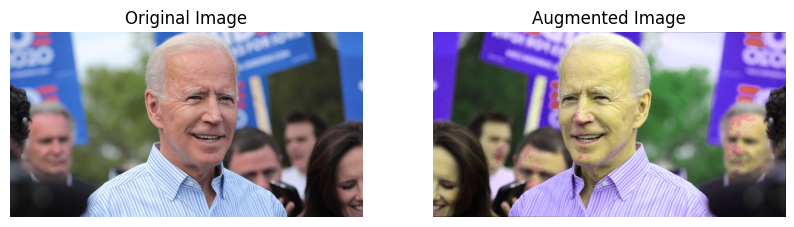

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint, uniform

# Augmentation parameters

augmentation_params = {
    'hsv_h': 0.1,  # Hue 변화
    'hsv_s': 0.1,  # Saturation 변화
    'hsv_v': 0.1,  # Value 변화
    'degrees': 0.1,  # 회전 각도
    'translate': 0.0,  # 이동
    'scale': 0.0,  # 크기 조정
    'shear': 0.1,  # Shearing (이미지 기울기를 부여합니다.)
    'perspective': 0.0, # 원근감을 부여합니다.
    'flipud': 0.0,  # 위 아래 반전
    'fliplr': 1.0,  # 좌우 반전
    'bgr': 0.0, #색 채럴
    'mosaic': 0.1,  # Mosaic augmentation
    'mixup': 0.1,
}


# Function to apply augmentations
def augment_image(image, params):
    augmented_images = []

    # HSV adjustments
    if params['hsv_h'] > 0:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 0] += int(params['hsv_h'] * 180)  # Convert hue adjustment to degrees
        hsv[:, :, 0] = np.clip(hsv[:, :, 0], 0, 179)  # Hue range is [0, 179]
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    if params['hsv_s'] > 0:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 1] = np.clip(hsv[:, :, 1] * (1 + params['hsv_s']), 0, 255)
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    if params['hsv_v'] > 0:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * (1 + params['hsv_v']), 0, 255)
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Rotation
    if params['degrees'] != 0:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, params['degrees'], 1.0)
        image = cv2.warpAffine(image, M, (w, h))

    # Translation
    if params['translate'] > 0:
        h, w = image.shape[:2]
        tx = int(params['translate'] * w)
        ty = int(params['translate'] * h)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        image = cv2.warpAffine(image, M, (w, h))

    # Scaling
    if params['scale'] > 0:
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), 0, params['scale'])
        image = cv2.warpAffine(image, M, (w, h))

    # Shearing
    if params['shear'] > 0:
        h, w = image.shape[:2]
        M = np.float32([[1, params['shear'] / 100, 0], [0, 1, 0]])
        image = cv2.warpAffine(image, M, (w, h))

    # Flipping
    if params['flipud'] > 0 and uniform(0, 1) < params['flipud']:
        image = cv2.flip(image, 0)  # Vertical flip

    if params['fliplr'] > 0 and uniform(0, 1) < params['fliplr']:
        image = cv2.flip(image, 1)  # Horizontal flip

    return image

# Load an example image
image_path = '/content/3467_10415_4819.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Augment the image
augmented_image = augment_image(image, augmentation_params)

# Display original and augmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [ ]:
augmentation_params = {
    'hsv_h': 0.1,  # Hue 변화
    'hsv_s': 0.7,  # Saturation 변화
    'hsv_v': 0.4,  # Value 변화
    'degrees': 10.0,  # 회전 각도
    'translate': 0.2,  # 이동
    'scale': 0.5,  # 크기 조정
    'shear': 10.0,  # Shearing
    'perspective': 0.0,
    'flipud': 0.5,  # 위 아래 반전
    'fliplr': 0.5,  # 좌우 반전
    'bgr': 0.0,
    'mosaic': 1.0,  # Mosaic augmentation
    'mixup': 0.0,
}

한번 yaml 불러와서 수정이 가능한지 확인해보기

# k-fold 중간 저장

In [ ]:
import os
from sklearn.model_selection import KFold
from ultralytics import YOLO

# 데이터셋과 KFold 설정
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# YOLOv8 모델을 불러오고, 체크포인트 디렉토리 설정
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 중단된 fold 확인 (로그 파일에서 읽어오기)
resume_file = "kfold_log.txt"
if os.path.exists(resume_file):
    with open(resume_file, "r") as f:
        start_fold = int(f.read().strip())  # 중단된 fold 번호
else:
    start_fold = 0  # 처음부터 시작

# 교차 검증 루프
def kfold_training(dataset, k_folds, start_fold=0, epochs=100, batch_size=16, img_size=640, model_type="yolov8n.pt"):
    model = YOLO(model_type)

    # K-Fold 교차 검증 시작
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

        # 중단된 fold 이후부터 학습 시작
        if fold < start_fold:
            print(f"Skipping fold {fold} (already completed)")
            continue

        print(f"FOLD {fold}")
        print("-------------------------------")

        # 학습 데이터와 검증 데이터를 나눔
        train_data = dataset[train_idx]
        val_data = dataset[val_idx]

        # 체크포인트 파일 경로 설정
        checkpoint_path = os.path.join(checkpoint_dir, f"fold_{fold}_last.pt")

        # 중단된 학습을 체크포인트에서 재개
        if os.path.exists(checkpoint_path):
            print(f"Resuming from checkpoint for fold {fold}")
            model = YOLO(checkpoint_path)
            model.train(data=train_data, epochs=epochs, batch=batch_size, imgsz=img_size, resume=True)
        else:
            print(f"Starting training for fold {fold}")
            model.train(data=train_data, epochs=epochs, batch=batch_size, imgsz=img_size)

        # 현재 fold 완료 후 체크포인트 저장
        model.save(checkpoint_path)

        # 현재 fold 번호를 로그 파일에 기록
        with open(resume_file, "w") as f:
            f.write(str(fold + 1))

# 예시로 사용할 데이터셋 (dataset 변수가 실제 데이터셋이어야 함)
dataset = ...  # 실제 데이터셋으로 교체

# 학습 재개
kfold_training(dataset, k_folds, start_fold=start_fold, epochs=100, batch_size=16, img_size=640, model_type="yolov8n.pt")
